# Manage interactive analyses

Capturing and documenting the origin and flow of biological data throughout its lifecycle is important as it enables the traceability and reliability of biological data & insights, verify experimental outcomes, meet stringent regulatory standards, and foster the reproducibility of scientific discoveries.

While tracking data lineage is easier when it's governed by deterministic pipelines, it becomes hard when interactive human-driven analyses become relevant.

This use case walks through how LaminDB helps with the latter by enabling to `ln.track()` data flow through notebooks & teams of analysts.

## Setup

```{warning}

Please ensure that you have created or loaded a LaminDB instance before running the remaining part of this notebook!
```

In [1]:
# A lamindb instance containing Bionty schema (skip if you already loaded your instance)
!lamin init --storage ./analysis-usecase --schema bionty

✅ Closed instance: testuser1/docsbuild
💬 Creating schemas: core==0.39.0 bionty==0.27.1 
✅ Saved: User(id=DzTjkKse, handle=testuser1, email=testuser1@lamin.ai, name=Test User1, updated_at=2023-07-20 12:22:25)
✅ Saved: Storage(id=sCZDjqa4, root=/Users/falexwolf/repos/lamin-usecases/docs/usecases/analysis-usecase, type=local, updated_at=2023-07-20 12:22:25, created_by_id=DzTjkKse)
✅ Loaded instance: testuser1/analysis-usecase
💡 Did not register local instance on hub (if you want to, call `lamin register`)


Import `lamindb` and `lnschema_bt` which enables us to connect [Bionty](https://github.com/laminlabs/bionty) with [LaminDB](https://github.com/laminlabs/lamindb). This enables us to map AnnData metadata annotations against ontologies and create SQL records within LaminDB to eventually make them queryable.

In [2]:
import lamindb as ln
import lnschema_bionty as lb

ln.settings.verbosity = 3  # show hints

✅ Loaded instance: testuser1/analysis-usecase (lamindb 0.48a1)


## Track cell types, tissues and diseases

Let's enable tracking of the current notebook as the transform of this file using {func}`docs:lamindb.track`:

In [3]:
ln.track()

💬 Notebook imports: lamindb==0.48a1 lnschema_bionty==0.26.1
✅ Saved: Transform(id=eNef4Arw8nNMQz, name=Manage interactive analyses, short_name=analyses, stem_id=eNef4Arw8nNM, version=0, type=notebook, updated_at=2023-07-20 12:22:34, created_by_id=DzTjkKse)
✅ Saved: Run(id=LK9kPTABS2XK7QTP9yxI, run_at=2023-07-20 12:22:34, transform_id=eNef4Arw8nNMQz, created_by_id=DzTjkKse)


We fetch an example dataset from LaminDB that has a few cell type, tissue and disease annotations:

In [4]:
adata = ln.dev.datasets.anndata_with_obs()
adata

AnnData object with n_obs × n_vars = 40 × 100
    obs: 'cell_type', 'cell_type_id', 'tissue', 'disease'

In [5]:
adata.obs[["tissue", "cell_type"]].value_counts()

tissue  cell_type              
brain   my new cell type           10
heart   hepatocyte                 10
kidney  T cell                     10
liver   hematopoietic stem cell    10
Name: count, dtype: int64

### Register biological metadata and link to the dataset

As a first step, we register the Anndata object with LaminDB using {func}`docs:lamindb.File` and {func}`docs:lamindb.save`:

In [6]:
file = ln.File(adata, key="mini_anndata_with_obs.h5ad")

💡 This is AnnDataLike, consider using File.from_anndata() to link var and obs.columns as features!
💡 File will be copied to storage upon `save()` using storage key = mini_anndata_with_obs.h5ad


In [7]:
file.save()

💡 storing file NRV4p4OeEcqnMA0T3GC1 with key mini_anndata_with_obs.h5ad


Using {func}`docs:lamindb.parse` we can associate the cell types and tissues with the Ontology metadata:

In [8]:
cell_types = lb.CellType.from_values(adata.obs.cell_type, lb.CellType.name)
tissues = lb.Tissue.from_values(adata.obs.tissue, lb.Tissue.name)

💬 Created 3 CellType records from Bionty that matched name field (bionty_source_id=DWJA)
🔶 Created 1 CellType record setting field name to: my new cell type


Output()

💬 Created 4 Tissue records from Bionty that matched name field (bionty_source_id=gn26)


Register the cell types and tissues with LaminDB:

In [9]:
ln.save(cell_types)
ln.save(tissues)

🔶 Now recursing through parents: this only happens once, but is much slower than bulk saving
💬 Also saving parents of CellType(id=J7hHC8SK, name=hepatocyte, ontology_id=CL:0000182, description=The Main Structural Component Of The Liver. They Are Specialized Epithelial Cells That Are Organized Into Interconnected Plates Called Lobules. Majority Of Cell Population Of Liver, Polygonal In Shape, Arranged In Plates Or Trabeculae Between Sinusoids; May Have Single Nucleus Or Binucleated., updated_at=2023-07-20 12:23:47, bionty_source_id=DWJA, created_by_id=DzTjkKse)
💬 Created 3 CellType records from Bionty that matched ontology_id field (bionty_source_id=DWJA)
🔶 Now recursing through parents: this only happens once, but is much slower than bulk saving
💬 Also saving parents of CellType(id=P6E7yrc7, name=epithelial cell, ontology_id=CL:0000066, synonyms=epitheliocyte, description=A Cell That Is Usually Found In A Two-Dimensional Sheet With A Free Surface. The Cell Has A Cytoskeleton That Allow

Associate the cell types and tissues with the {func}`docs:lamindb.File` object.

In [10]:
file.cell_types.set(cell_types)
file.tissues.set(tissues)

### Your vocabulary store

Examine the currently available cell types and tissues:

In [11]:
lb.CellType.select().df()

,name,ontology_id,abbr,synonyms,description,bionty_source_id,updated_at,created_by_id
id,,,,,,,,
J7hHC8SK,hepatocyte,CL:0000182,None,None,The Main Structural Component Of The Liver. Th...,DWJA,2023-07-20 14:23:47,DzTjkKse
CbEpmr0T,my new cell type,None,None,None,None,None,2023-07-20 14:23:47,DzTjkKse
BxNjby0x,T cell,CL:0000084,None,T-cell|T lymphocyte|T-lymphocyte,A Type Of Lymphocyte Whose Defining Characteri...,DWJA,2023-07-20 14:23:47,DzTjkKse
m91LZBDZ,hematopoietic stem cell,CL:0000037,None,hemopoietic stem cell|HSC|blood forming stem cell,A Stem Cell From Which All Cells Of The Lympho...,DWJA,2023-07-20 14:23:47,DzTjkKse
P6E7yrc7,epithelial cell,CL:0000066,None,epitheliocyte,A Cell That Is Usually Found In A Two-Dimensio...,DWJA,2023-07-20 14:23:47,DzTjkKse
QMAH6IlS,somatic cell,CL:0002371,None,None,A Cell Of An Organism That Does Not Pass On It...,DWJA,2023-07-20 14:23:47,DzTjkKse
AOy0Et6k,endopolyploid cell,CL:0000417,None,None,None,DWJA,2023-07-20 14:23:47,DzTjkKse
H0taCt24,animal cell,CL:0000548,None,metazoan cell,A Native Cell That Is Part Of Some Metazoa.,DWJA,2023-07-20 14:23:48,DzTjkKse
igNGxgJT,eukaryotic cell,CL:0000255,None,None,None,DWJA,2023-07-20 14:23:49,DzTjkKse


In [12]:
lb.Tissue.select().df()

,name,ontology_id,abbr,synonyms,description,bionty_source_id,updated_at,created_by_id
id,,,,,,,,
sm45H0wI,heart,UBERON:0000948,None,chambered heart|vertebrate heart,A Myogenic Muscular Circulatory Organ Found In...,gn26,2023-07-20 14:23:53,DzTjkKse
7HcGzG0l,brain,UBERON:0000955,None,None,The Brain Is The Center Of The Nervous System ...,gn26,2023-07-20 14:23:53,DzTjkKse
j9lTWyWV,kidney,UBERON:0002113,None,None,A Paired Organ Of The Urinary Tract Which Has ...,gn26,2023-07-20 14:23:53,DzTjkKse
HHKnN309,liver,UBERON:0002107,None,None,An Exocrine Gland Which Secretes Bile And Func...,gn26,2023-07-20 14:23:53,DzTjkKse
LB1DWmLh,structure with developmental contribution from...,UBERON:0010314,None,None,An Anatomical Structure That Has Some Part Tha...,gn26,2023-07-20 14:23:54,DzTjkKse
w6ZLPLvC,mesoderm-derived structure,UBERON:0004120,None,mesodermal derivative,An Anatomical Structure That Develops (Entirel...,gn26,2023-07-20 14:23:54,DzTjkKse
J3XUWZki,primary circulatory organ,UBERON:0007100,None,None,"A Hollow, Muscular Organ, Which, By Contractin...",gn26,2023-07-20 14:23:54,DzTjkKse
zURRkybM,thoracic segment organ,UBERON:0005181,None,None,An Organ That Part Of The Thoracic Segment Reg...,gn26,2023-07-20 14:23:54,DzTjkKse
eEntTihh,anatomical structure,UBERON:0000061,None,connected biological structure|biological stru...,Material Anatomical Entity That Is A Single Co...,gn26,2023-07-20 14:23:54,DzTjkKse


## Processing of the dataset

In the following we will modify the AnnData object to demonstrate data lineage tracking with LaminDB.

To track our data transformation we create a new {func}`docs:lamindb.Transform` of type "pipeline":

In [13]:
transform = ln.Transform(
    type="pipeline", name="subset_to_T_cells_and_liver_lymphoma", version="0.1.0"
)

Set the current tracking to the new transform using {func}`docs:lamindb.track`:

In [14]:
ln.track(transform)

✅ Saved: Transform(id=5Q9bT40xl2aa9p, name=subset_to_T_cells_and_liver_lymphoma, stem_id=5Q9bT40xl2aa, version=0.1.0, type=pipeline, updated_at=2023-07-20 12:24:27, created_by_id=DzTjkKse)
✅ Saved: Run(id=8gjWqOb9c9bfKb7ojedf, run_at=2023-07-20 12:24:27, transform_id=5Q9bT40xl2aa9p, created_by_id=DzTjkKse)


### Get a cloud-backed AnnData object

In [15]:
file = ln.File.select(key="mini_anndata_with_obs.h5ad").one()

In [16]:
adata = file.backed(is_run_input=True)
adata

/Users/falexwolf/miniconda3/envs/py39/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 40 × 100 backed at '/Users/falexwolf/repos/lamin-usecases/docs/usecases/analysis-usecase/mini_anndata_with_obs.h5ad'
    obs: 'cell_type', 'cell_type_id', 'tissue', 'disease'

In [17]:
adata.obs[["cell_type", "disease"]].value_counts()

cell_type                disease                   
T cell                   chronic kidney disease        10
hematopoietic stem cell  liver lymphoma                10
hepatocyte               cardiac ventricle disorder    10
my new cell type         Alzheimer disease             10
Name: count, dtype: int64

### Subset dataset to specific cell types and diseases

Create the subset:

In [18]:
subset_obs = adata.obs.cell_type.isin(["T cell", "hematopoietic stem cell"]) & (
    adata.obs.disease.isin(["liver lymphoma", "chronic kidney disease"])
)

In [19]:
adata_subset = adata[subset_obs]
adata_subset

View of AnnData object with n_obs × n_vars = 20 × 100 backed at '/Users/falexwolf/repos/lamin-usecases/docs/usecases/analysis-usecase/mini_anndata_with_obs.h5ad'
    obs: 'cell_type', 'cell_type_id', 'tissue', 'disease'

In [20]:
adata_subset.obs[["cell_type", "disease"]].value_counts()

cell_type                disease               
T cell                   chronic kidney disease    10
hematopoietic stem cell  liver lymphoma            10
Name: count, dtype: int64

### Add the subset `AnnData` to LaminDB

This subset can now be registered with LaminDB.

In [21]:
file_subset = ln.File(adata_subset.to_memory(), key="subset/mini_anndata_with_obs.h5ad")

/Users/falexwolf/miniconda3/envs/py39/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


💡 This is AnnDataLike, consider using File.from_anndata() to link var and obs.columns as features!
💡 File will be copied to storage upon `save()` using storage key = subset/mini_anndata_with_obs.h5ad


In [22]:
file_subset.save()

💡 storing file tl8ehtsEjukp4Ub4UaYR with key subset/mini_anndata_with_obs.h5ad


Link the subsetted file to cell types:

In [23]:
cell_types = lb.CellType.from_values(adata_subset.obs.cell_type, lb.CellType.name)

💬 Loaded 2 CellType records that matched field name


In [24]:
file_subset.cell_types.set(cell_types)

## Examining data lineage

Common questions that might arise are:

- Which h5ad file is in the `subset` subfolder?
- Which notebook ingested this file?
- By whom?
- And which file is its parent?

Let's answer this using LaminDB:

Query a subsetted `.h5ad` file containing "hematopoietic stem cell" and "T cell" to learn which h5ad file is in the `subset` subfolder:

In [25]:
cell_types_bt_lookup = lb.CellType.lookup()

In [26]:
le_subset = ln.File.select(
    suffix=".h5ad",
    key__startswith="subset",
    cell_types__in=[
        cell_types_bt_lookup.hematopoietic_stem_cell,
        cell_types_bt_lookup.t_cell,
    ],
).first()

In [27]:
le_subset

File(id=tl8ehtsEjukp4Ub4UaYR, key=subset/mini_anndata_with_obs.h5ad, suffix=.h5ad, size=38992, hash=WIdz5wyaAbZXAEIK-tWMsA, hash_type=md5, updated_at=2023-07-20 12:24:51, storage_id=sCZDjqa4, transform_id=5Q9bT40xl2aa9p, run_id=8gjWqOb9c9bfKb7ojedf, created_by_id=DzTjkKse)

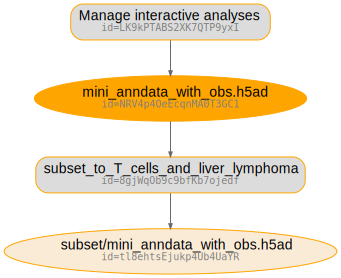

In [29]:
file.view_lineage()

Which notebook ingested this file?

In [28]:
file_subset.transform

Transform(id=5Q9bT40xl2aa9p, name=subset_to_T_cells_and_liver_lymphoma, stem_id=5Q9bT40xl2aa, version=0.1.0, type=pipeline, updated_at=2023-07-20 12:24:51, created_by_id=DzTjkKse)

Who ingested this file?

In [30]:
file_subset.created_by

User(id=DzTjkKse, handle=testuser1, email=testuser1@lamin.ai, name=Test User1, updated_at=2023-07-20 12:22:25)

What are the parent files?

In [32]:
file_subset.run.input_files.list("key")

['mini_anndata_with_obs.h5ad']

In [33]:
!lamin delete analysis-usecase
!rm -r ./analysis-usecase

💬 Deleting instance testuser1/analysis-usecase
💬     deleted instance settings file: /Users/falexwolf/.lamin/instance--testuser1--analysis-usecase.env
✅ Closed instance: testuser1/analysis-usecase
💬     instance cache deleted
💬     deleted '.lndb' sqlite file
💬     manually delete your stored data: /Users/falexwolf/repos/lamin-usecases/docs/usecases/analysis-usecase
